In [1]:
import cv2 as cv
import tensorflow as tf
import keras
import os
import pandas as pd
import shutil
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
import numpy as np
from keras.models import Model
from keras.layers import Input, Activation, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array,random_rotation
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array,random_rotation
import requests
from io import BytesIO
from PIL import Image
import PIL

# Data Preparation

In [38]:
df = pd.read_csv('dataset/train.csv')
df.head()

,nomor,jenis kelamin,usia
0,1,0,27
1,2,1,24
2,3,0,29
3,4,1,23
4,5,0,20


In [44]:
df.usia.value_counts()

24    90
25    88
27    87
26    70
28    54
23    50
22    43
30    38
29    37
21    30
32    24
20    20
31    14
18    14
17    14
34    14
19    13
35    10
33     9
16     6
37     6
36     5
40     5
38     4
42     4
47     3
41     3
6      2
7      2
43     2
39     2
46     1
45     1
5      1
15     1
13     1
8      1
50     1
Name: usia, dtype: int64

In [3]:
X = df['nomor']
y = df['jenis kelamin']

In [4]:
#membagi data menjadi data training & data testing

from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X,y, test_size=0.25, random_state=0)

In [77]:
# membuat dataframe untuk masing2 hasil pembagian train & test
# menambah kolom set sbg keterangan tes atau train

df_train = pd.DataFrame({
    'no' : X_train,
    'jk' : y_train,
    'set' : 'train'
})

df_val = pd.DataFrame({
    'no':X_test,
    'jk':y_test,
    'set':'validation'
})

In [79]:
df_full = pd.concat([df_train, df_val])
df_full.tail()

,no,jk,set
642,643,0,validation
302,303,1,validation
760,761,1,validation
140,141,0,validation
312,313,0,validation


In [154]:
df_full.to_csv('divided_data.csv',index=False)

In [35]:
file_name = []
for root, folders ,files in (os.walk(base_path)):
    file_name.append(files)
file_name.pop(0)
len(file_name)

770

In [5]:
source_path = 'dataset/training/'
dest_path = 'dataset/data/'

# Memindahkan dataset ke folder berdasarkan kelasnya

In [127]:
def copy(src, dst):
    if os.path.isdir(dst):
        dst = os.path.join(dst, os.path.basename(src))
    shutil.copyfile(src, dst)

for index, row in tq(df_full.iterrows()):
    
    if os.path.exists(os.path.join(dest_path,row['set'],str(row['jk']))) == False:
        os.makedirs(os.path.join(dest_path,row['set'],str(row['jk'])))
        
    dir_path = os.path.join(source_path, str(row['no']))
    
    for file in os.listdir(dir_path):
        src = os.path.join(dir_path,file)
        dest = os.path.join(dest_path, row['set'], str(row['jk']), file)
        
        if os.path.exists(dest) == False:
            copy(src,dest)

0it [00:00, ?it/s]

# Periksa perbandingan class pada data training

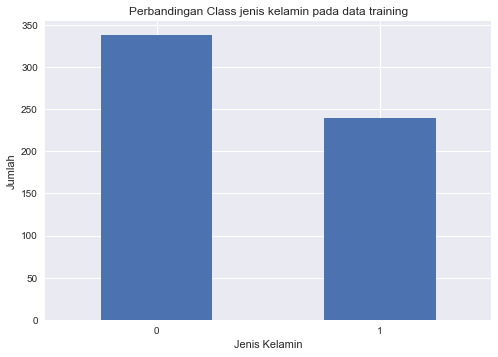

In [144]:
df_train.groupby('jk')['no'].count().plot(kind='bar')
plt.style.use('seaborn')
plt.title('Perbandingan Class jenis kelamin pada data training')
plt.xlabel('Jenis Kelamin')
plt.xticks(rotation=0)
plt.ylabel('Jumlah')
plt.show()

## Crop Image to get only face area

In [ ]:
train_dir = 'dataset/data/train/'
val_dir = 'dataset/data/validation/'

In [ ]:
# algoritma -> periksa setiap face, apakah mengandung face lagi
# jika iya maka itu benar area wajah, lalu save
# sampai ke perulangan terakhir
# perlu diubah untuk direktori data train dan data test

not_cropped = []
for idx,file in enumerate(os.listdir(os.path.join(train_dir,'0'))):

    img_name = file
    img = cv2.imread(f'dataset/data/train/0/{img_name}')

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

    i=0
    save=False
    for (x,y,w,h) in faces:
#         print(i)
        cv2.rectangle(gray, (x,y), (x+w,y+h), (0,255,0), 2) # BLUE, GREEN, RED
        rec_image = img[y:y+h, x:x+w]
        faces2 = face_cascade.detectMultiScale(rec_image, scaleFactor=1.1, minNeighbors=5)
        if len(faces2) != 0:
            save = True
            crop_path = f"dataset/crop_data/train/000/{img_name}_cropped_{i}.jpg"
            cv2.imwrite(crop_path, rec_image)
        i += 1
    if save == False:
        not_cropped.append(file)
    #     break

# Generate Image

In [2]:
img_width = 64
img_height = 64
epochs = 30
batch_size = 32
dataset_path = 'dataset/clean_data/'

In [3]:
#define path data train & tes untuk generator

train_dir = os.path.join(dataset_path,'train')
val_dir = os.path.join(dataset_path,'validation')

In [4]:
# Training Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    horizontal_flip=True
)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode = "grayscale",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1610 images belonging to 2 classes.


In [5]:
val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
#     color_mode = 'grayscale',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 517 images belonging to 2 classes.


In [7]:
sum_train_files = len(os.listdir(os.path.join(train_dir,'0'))) + len(os.listdir(os.path.join(train_dir,'1')))
sum_val_files = len(os.listdir(os.path.join(val_dir,'0'))) + len(os.listdir(os.path.join(val_dir,'1')))
print(sum_train_files)
print(sum_val_files)

1610
517


# Model Architecture CNN

In [19]:
# # imported layers
# from keras.layers import Input, Activation,
# Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten
# Conv2D?

# padding same = [0]
# padding valid = no padding around
# padding same means output shape will be same as input shape

## Data Augmentation

In [8]:
data_augmentation = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [8]:
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
#     data_augmentation,
#     section 1
    Conv2D(8, (3,3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(),
#    section 2
    Conv2D(16, (3,3), strides=(1,1), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(),
#     section 3
    Conv2D(32, (3,3), strides=(1,1), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(),
#     section 4
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, (3,3), strides=(1,1), padding='valid',activation='relu'),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    MaxPooling2D(strides=(2,2), padding='same'),
#     section 5
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    Conv2D(128, (3,3), strides=(1,1), padding='valid',activation='relu'),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    MaxPooling2D(strides=(2,2), padding='same'),
#     section 6
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    Conv2D(256, (3,3), strides=(1,1), padding='valid',activation='relu'),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    MaxPooling2D(strides=(2,2), padding='same'),
#     section 7
#     tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
#     Conv2D(512, (3,3), strides=(1,1), padding='valid',activation='relu'),
#     tf.keras.layers.BatchNormalization(),
# #     tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
#     MaxPooling2D(strides=(2,2), padding='same'),
#     section 8 dropout & fc_layers
    tf.keras.layers.Dropout(.5),
    Flatten(),
    Dense(100, activation='relu'),
    tf.keras.layers.Dropout(.5),
    Dense(50, activation='relu'),
    tf.keras.layers.Dropout(.5),
    Dense(1, activation='sigmoid'),
])

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min', patience=5)

In [10]:
model.compile(optimizer='adam',
                loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator.filenames)//batch_size,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[callback],
    validation_steps = len(val_generator.filenames)//batch_size
)

Epoch 1/30
50/50 [==============================] - 28s 532ms/step - loss: 1.0206 - accuracy: 0.5767 - val_loss: 0.7195 - val_accuracy: 0.4141
Epoch 2/30
50/50 [==============================] - 9s 183ms/step - loss: 0.7149 - accuracy: 0.6280 - val_loss: 0.7611 - val_accuracy: 0.4121
Epoch 3/30
50/50 [==============================] - 9s 175ms/step - loss: 0.5551 - accuracy: 0.7402 - val_loss: 0.7080 - val_accuracy: 0.4258
Epoch 4/30
50/50 [==============================] - 9s 173ms/step - loss: 0.4641 - accuracy: 0.7909 - val_loss: 0.6565 - val_accuracy: 0.5781
Epoch 5/30
50/50 [==============================] - 8s 163ms/step - loss: 0.3822 - accuracy: 0.8365 - val_loss: 0.5451 - val_accuracy: 0.8223
Epoch 6/30
50/50 [==============================] - 8s 157ms/step - loss: 0.3390 - accuracy: 0.8530 - val_loss: 0.4474 - val_accuracy: 0.8398
Epoch 7/30
50/50 [==============================] - 9s 186ms/step - loss: 0.2844 - accuracy: 0.8758 - val_loss: 0.3916 - val_accuracy: 0.7832
Epoch

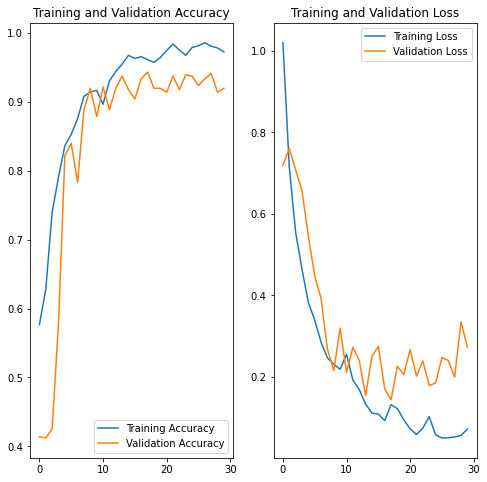

In [13]:
# epochs = 21
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(val_generator, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest Lost:', test_loss)

17/17 - 1s - loss: 0.2701 - accuracy: 0.9207

Test accuracy: 0.9206963181495667

Test Lost: 0.2700725197792053


In [28]:
import requests
from io import BytesIO
from PIL import Image
import PIL
# import numpy as np
# Parameters
input_size = (64,64)
#define input shape
channel = (3,)
input_shape = input_size + channel
#define labels
labels = [0, 1]

def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array,random_rotation

# crop face image

Male  0.99591285


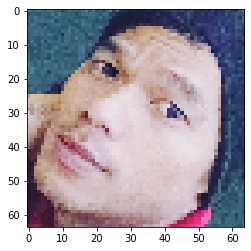

In [21]:
path = '59dda362-9928-4519-98a2-1bb11f439ec7'
img_path = f'dataset/temp_cropped_test/{path}.jpg'
# img_path = 'test_data/tes1.jpg'

img = load_img(img_path, target_size=(64,64,3))
plt.imshow(img)

img = img_to_array(img)
img = img/255.0
img = img.reshape(1,64,64,3)

prob = model.predict(img)
if prob[0] > 0.5 :
    print('Male ', prob[0][0])
# ax[idx].text(70, 2,s=f"Male")
else:
    print('Female ', prob[0][0])
#         ax[idx].text(70, 2, s=f"Female")


In [41]:
model.save('new_model_94.h5')

# Predict and Save Result CSV

In [22]:
def pred(path):
    img_path = f'dataset/temp_cropped_test/{path}.jpg'

    img = load_img(img_path, target_size=(img_width,img_height,3))

    img = img_to_array(img)
    img = img/255.0
    img = img.reshape(1,img_width,img_height,3)

    prob = model.predict(img)
    if prob[0] > 0.5 :
        return 1
    else:
        return 0

In [23]:
submission = pd.read_csv('dataset/submission.csv')
submission['jenis kelamin'] = submission['id'].apply(lambda x : pred(x))

In [26]:
submission

,id,jenis kelamin
0,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27,1
1,0052554e-069e-4c43-beb0-0885e8f7684e,1
2,0092b954-1143-4a95-a17b-1edfa6af3b01,0
3,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16,0
4,00d0e306-06fe-45d8-ae6c-6f83ab8f7810,1
...,...,...
985,feb9e70f-4182-4500-866d-9b95657e727c,0
986,fed67ed2-620a-4ebf-b61e-16ef3d9b93f7,0
987,ff14c77e-c3c2-46db-9341-30de4130ef8a,1
988,ff662f3f-8c76-4d27-a73e-c43c4353f798,1


In [51]:
submission

,id,jenis kelamin
0,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27,1
1,0052554e-069e-4c43-beb0-0885e8f7684e,1
2,0092b954-1143-4a95-a17b-1edfa6af3b01,0
3,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16,0
4,00d0e306-06fe-45d8-ae6c-6f83ab8f7810,1
5,00f7b619-513e-4e43-bc32-ec49d233e09e,0
6,00fe5537-1e84-46b3-ab06-c19d8c914794,0
7,0111e4e4-ffbb-427b-b99f-e6162f155051,0
8,01122df2-dc9f-4b37-a42c-5b79318a6773,0
9,0193230d-b30e-487d-886e-e5bddf06ce69,0


In [53]:
submission.to_csv('last_submission.csv', index=False)

In [29]:
sub1 = pd.read_csv('last_submission.csv')
sub1

,id,jenis kelamin
0,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27,1
1,0052554e-069e-4c43-beb0-0885e8f7684e,1
2,0092b954-1143-4a95-a17b-1edfa6af3b01,0
3,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16,0
4,00d0e306-06fe-45d8-ae6c-6f83ab8f7810,1
...,...,...
985,feb9e70f-4182-4500-866d-9b95657e727c,0
986,fed67ed2-620a-4ebf-b61e-16ef3d9b93f7,0
987,ff14c77e-c3c2-46db-9341-30de4130ef8a,1
988,ff662f3f-8c76-4d27-a73e-c43c4353f798,1
